# Scraping lyrics from Genius.com

Using libraries requests and BeautifulSoup, the code is used to scrape the lyrics of one or multiple songs from the website genius.com

Next, the data can be used to create charts that, for example, define the amount of times a specific word is said.

In [1]:
# standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# including libraries for web scraping
import requests
from bs4 import BeautifulSoup as bs
# including a library to convert datetime format
import datetime

In [528]:
# including selenium to do allow access to javascript elements
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import os, sys

# appending the path where the driver that selenium needs to access the internet is
sys.path.append("C:/Users/Matthijs/Documents/Python")

driver = webdriver.Chrome(chrome_options = options, executable_path = r'C:/Users/Matthijs/Documents/Python/chromedriver.exe')

In [214]:
# creating a dict to store the title, lyrics and comments on the song

song = {}
song["Artist"] = []
song["Title"] = []
song["Lyrics"] = []
song["Release Date"] = []
song["Album"] = []

In [332]:
# function that retrieves a song's information

def get_song(song_artist, song_title):
    if song_artist[-1] == ' ':
        song_artist = song_artist[0:-1]
    if song_title[-1] == ' ':
        song_title = song_title[0:-1]
    try:
        song_url = "https://genius.com/{}-{}-lyrics".format(re.sub(r'\W+', ' ', song_artist).replace(' ', '-'), 
                                                            re.sub(r'\W+', ' ', song_title).replace(' ', '-'))
        res = requests.get(song_url)
        soup = bs(res.content, 'html.parser')

        # extracting the artist, title and release date
        for song_title in soup.findAll('title'):
            song_title = song_title.text.strip()
        song["Artist"].append(song_title.split(u"\u2013")[0].encode('ascii', 'replace').replace("?", ' '))
        song["Title"].append(song_title.split(u"\u2013")[1].split("Lyrics")[0].encode('ascii', 'replace').replace("?", ' '))

        # extracting the lyrics
        for div in soup.findAll('div', attrs = {'class': 'lyrics'}):
            song["Lyrics"].append(div.text.strip().split("\n"))

        # extracting the release date
        for span in soup.findAll('span', attrs = {'class': 'metadata_unit-info metadata_unit-info--text_only'}):
            try:
                song["Release Date"] = datetime.datetime.strftime(datetime.datetime.strptime(str(span.text.strip()), "%B %d, %Y"), 
                                                                  "%Y-%m-%d")
            except:
                next

        # extracting the album
        for a in soup.findAll('a', attrs = {'class': 'song_album-info-title'}):
            song["Album"].append(a.text.strip().encode('ascii', 'replace').replace("?", ' '))
    except:
        print "url {} not found".format(song_url)

In [443]:
get_song("Billie Eilish", "bad guy")

In [165]:
# seperating all the words in the song lyrics in a seperate list. Also includes notations about who sings the song, 
# and what part of the song it is.
song_nr = 0
wordlist = []
for line in song["Lyrics"][song_nr]:
    for word in line.split():
        wordlist.append(re.sub(r'\W+', '', word).lower())  # removing non-alphanumerical characters and making it all lowercase

wordframe = pd.DataFrame(columns = ["word", "count"])

for word in np.unique(wordlist):
    wordframe = wordframe.append(pd.DataFrame([[word, wordlist.count(word)]], columns = ["word", "count"]))

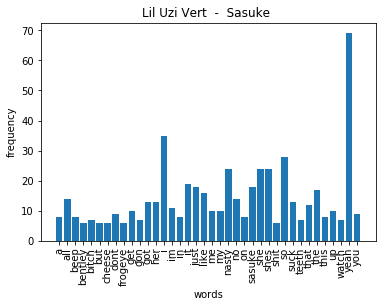

In [166]:
# filtering the words with low frequency out
selected = np.where(wordframe["count"] > 5)

plt.bar(wordframe["word"].iloc[selected[0]], wordframe["count"].iloc[selected[0]])
plt.title("{} - {}".format(str(song["Artist"][song_nr]), str(song["Title"][song_nr])))
plt.ylabel("frequency")
plt.xlabel("words")
plt.xticks(rotation = 90)
plt.show()

In [304]:
album_artist = "kanye west"
album_title = "my beautiful dark twisted fantasy"
album_url = "https://genius.com/albums/{}/{}".format(album_artist.replace(" ", "-"), album_title.replace(" ", "-"))
album_url

'https://genius.com/albums/kanye-west/my-beautiful-dark-twisted-fantasy'

In [309]:
def get_album(album_artist, album_title): 
    album_url = "https://genius.com/albums/{}/{}".format(album_artist.replace(" ", "-"), album_title.replace(" ", "-"))
    res = requests.get(album_url)
    soup = bs(res.content, "html.parser")
    album_songs = []
    for div in soup.findAll('h3', attrs = {'class': 'chart_row-content-title'}):
            album_songs.append(str(div.text.strip().encode('ascii', 'replace').replace("?", ' ').split("\n")[0].split("(")[0]))
            #print div.text.strip().split("\n")[0]
            #print div
    return album_songs

In [442]:
# creating a dict to store the title, lyrics and comments on the song

song = {}
song["Artist"] = []
song["Title"] = []
song["Lyrics"] = []
song["Release Date"] = []
song["Album"] = []

In [568]:
album_title = "de lachende derde"
album_artist = "de jeugd van tegenwoordig"
album_songs = get_album(album_artist, album_title)

In [569]:
for songs in album_songs:
    get_song(album_artist, songs)

url https://genius.com/de-jeugd-van-tegenwoordig-De-Lachende-Derde-Tracklist-Cover--lyrics not found


In [573]:
# seperating all the words in the song lyrics in a seperate list. Also includes notations about who sings the song, 
# and what part of the song it is.

wordframe = pd.DataFrame(columns = ["song", "word", "count"])
chosen_word = "de"

for i, songs in enumerate(song["Title"]):
    wordlist = []
    for line in song["Lyrics"][i]:
        if len(line) > 0 and line[0] == '[':
            continue
        for word in line.split():
            wordlist.append(re.sub(r'\W+', '', word).lower())  # removing non-alphanumerical characters and making it all lowercase
    wordframe = wordframe.append(pd.DataFrame([[songs, chosen_word, wordlist.count(chosen_word)]], columns = ["song", "word", "count"]))

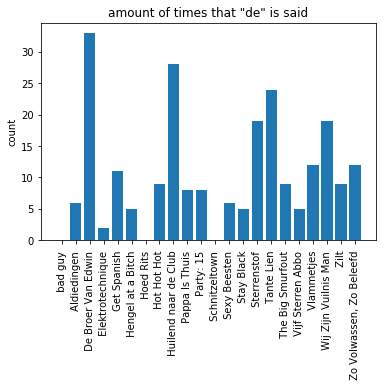

In [574]:
plt.bar(wordframe["song"], wordframe["count"])
plt.title("amount of times that \"{}\" is said".format(chosen_word, album_title))
plt.ylabel("count")
plt.xticks(rotation = 90)
plt.show()